# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [1]:
import os
from xml.etree import ElementTree
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy

from skimage.filters import rank
from skimage.morphology import disk


from skimage import filters
from skimage.future import graph

from skimage import measure
from scipy import special

from IPython.display import Markdown, display


In [2]:
%matplotlib inline


In [3]:
%pdb

Automatic pdb calling has been turned ON


In [5]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CC3D_sims/'

folder_num = 1


data_dirs = os.listdir(DATA_ROOT)
data_dirs.sort()
data_dirs = [os.path.join(DATA_ROOT, d) for d in data_dirs]
data_dirs = [d for d in data_dirs if os.path.isdir(d)]


data_dir = data_dirs[folder_num]


def parse_cc3d(data_dir, simname):
    
    sim_dict = {}
    sim_str = []

    sim_str.append('## File used: ')
    sim_str.append('Using: `{}`'.format(data_dir))

    
    xml_file = os.path.join(data_dir+'/Simulation/{}.xml'.format(simname))
    py_file = os.path.join(data_dir+'/Simulation/{}Steppables.py'.format(simname))

    xml_tree = ElementTree.ElementTree(file=xml_file)
    xml_root = xml_tree.getroot()

    for child in xml_root:

        if child.tag == 'Potts':
            steps = int(child.find('Steps').text)
            dim = {k: int(v) for k, v 
                   in child.find('Dimensions').items()}
            sim_dict['dim'] = dim
            sim_dict['steps'] = steps
        elif child.get('Name') == 'Contact':
            energies = child.findall('Energy')
            energies = {'{}-{}'.format(energy.attrib['Type1'],
                                       energy.attrib['Type2']):
                        float(energy.text) for energy in energies}

    sim_dict['energies'] = energies
    
    sim_str.append('<hr/>')
    sim_str.append('## Energies: ')
    for k, v in energies.items():
        sim_str.append('{}: {}'.format(k, v))
    

    pysettings = []
    
    with open(py_file) as pf:
        start_parse = False
        for line in pf.readlines():
            if line.startswith('# <parameter settings>'):
                start_parse = True
            elif (start_parse 
                  and not line.startswith('#')
                  and len(line) > 3):
                pysettings.append(line[:-1])
            elif line.startswith('# </parameter settings>'):
                break
    
    
    sim_dict['pysettings'] = pysettings
    
    sim_str.append('<hr/>\n')
    sim_str.append('## python set variables:')
    for p in pysettings:
        sim_str.append(p)

    vtk_dir = os.path.join(data_dir,'LatticeData')

    vtk_files = [os.path.join(vtk_dir, f) 
                 for f in os.listdir(vtk_dir)
                 if f.endswith('.vtk')]
    vtk_files.sort()
    sim_dict['vtk_files'] = vtk_files
    
    sim_str.append('<hr/> \n')
    sim_str.append('##  VTK files\n')
    sim_str.append('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))
    return sim_dict, sim_str

sim_dict, sim_str = parse_cc3d(data_dir, simname='Sim2')

sim_dict['pysettings']
exec(' '.join(sim_dict['pysettings'])) #of course this is unsafe, I know it
sim_dict['py_params'] = params.copy()

import json
with file(data_dir+'.json', 'w') as fp:
    json.dump(sim_dict, fp)

    



display(Markdown('\n \n'.join(sim_str)))
#for l in sim_str: print(l)

## File used: 
 
Using: `/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_15_51`
 
<hr/>
 
## Energies: 
 
Medium-CancerStemCell: 10.0
 
CancerStemCell-CancerStemCell: 1.0
 
CancerStemCell-NonCancerous: 10.0
 
NonCancerous-NonCancerous: 1.0
 
Medium-Medium: 10.0
 
Medium-NonCancerous: 10.0
 
<hr/>

 
## python set variables:
 
params = {
 
    'growth_rate': 1.,
 
    'P_sr': 0.6,
 
    'P_ar': 0.2,
 
    'cell_critical_volume': 50,
 
    'targetVolume': 25,
 
    'lambdaVolume': 10,
 
    'prolif_potential': 4,
 
    }
 
<hr/> 

 
##  VTK files

 
starts: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_15_51/LatticeData/Step_000.vtk
 stops: /home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_15_51/LatticeData/Step_460.vtk

In [6]:
for d in data_dirs: print(d)

/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_17_2015_15_50_28
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_15_51
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_16_24
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_16_51
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_17_23
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_17_54
/home/guillaume/Projets/NeuroBlasts/CC3D_sims/Sim2_cc3d_09_19_2015_12_18_28


In [8]:
def parse_vtk(vtk_file, sim_dict, data_fields):
    
    dim = sim_dict['dim']
    reader = vtk.vtkStructuredPointsReader()
    #reader = vtkUnstructuredGridReader()
    reader.SetFileName(vtk_file)
    reader.Update()
    field_data = reader.GetOutput()
    out_data = {}
    for data_field in data_fields:
        out_data[data_field] = vtk_to_numpy(
            field_data.GetPointData().GetArray(data_field)).reshape((dim['x'], dim['y']))
    reader.CloseVTKFile()
    return out_data    
    
field_names = ['CellType', 'CellId', 'CellAge'] # 'ClusterId' is not used yet

def parse_all_vtks(vtk_files, sim_dict, field_names):
    num_steps = len(vtk_files)
    dim = sim_dict['dim']
    data_fields = {field: np.zeros((num_steps, dim['x'], dim['y']))
                   for field in field_names}
    step_values = []
    for i, vtk_file in enumerate(vtk_files):
        step_values.append(int(vtk_file.split('.')[0][-3:]))
        frame_data = parse_vtk(vtk_file, sim_dict, field_names)
        for key, val in frame_data.items():
            data_fields[key][i] = val
    return data_fields, np.array(step_values)

data_fields, step_values = parse_all_vtks(sim_dict['vtk_files'], sim_dict, field_names)


In [9]:

def get_pix_entropy():
    pix_entropy = rank.entropy(cell_type_field.astype(np.uint8), disk(2))

    
data_fields['PixelEntropy'] = np.array([rank.entropy(cell_type.astype(np.uint8), disk(2))
                                        for cell_type in data_fields['CellType']])


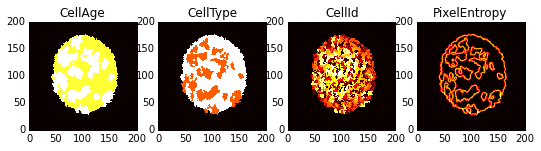

In [10]:
dpi = 90. # pixel per inch 
pix_width = 800
pix_height = 300

%matplotlib inline
vtk_fnum = 15
f_size_i = (pix_width/dpi, pix_height/dpi)


fig, axes = plt.subplots(1, len(data_fields))
fig.set_size_inches(f_size_i)


for ax, (name, field) in zip(axes, data_fields.items()):
    ax.imshow(field[vtk_fnum], cmap='hot', origin='lower', interpolation='nearest')
    ax.set_title(name, fontdict={'fontsize':12})


In [ ]:
def get_idxs(data_fields, step_values):
    cell_types, cell_ids = data_fields['CellType'], data_fields['CellId']
    e_idx = []
    v_idx = []
    for mcs, cell_type, cell_id in zip(step_values, cell_types, cell_ids):
        rag = graph.rag_mean_color(cell_type, cell_id)
        direct = [(mcs, s, t) for s, t in rag.edges()]
        fliped = [(mcs, t, s) for s, t in rag.edges()]
        e_idx.extend(direct + fliped)
        v_idx.extend([(mcs, cell_id) for cell_id in rag.nodes()])

    e_idx = pd.MultiIndex.from_tuples(e_idx, 
                                      names=['t', 'srce', 'trgt'])
    v_idx = pd.MultiIndex.from_tuples(v_idx, 
                                      names=['t', 'cell'])
    return v_idx, e_idx

v_idx, e_idx = get_idxs(data_fields, step_values)

In [ ]:
cell_data = ['type', 'age', 'area', 'cx', 'cy']
    
cell_df = pd.DataFrame(index=v_idx, columns=cell_data)
for i, mcs in enumerate(step_values):
    cell_type = data_fields['CellType'][i]
    cell_id = data_fields['CellId'][i]
    cell_age = data_fields['CellAge'][i]
    properties = measure.regionprops(cell_id.astype(np.int))
    for p in properties:
        lbl = p['label']
        cell_df.loc[(mcs, lbl), 'area'] = p['area']
        cx, cy = p['centroid']
        cell_df.loc[(mcs, lbl), 'cx'] = cx
        cell_df.loc[(mcs, lbl), 'cy'] = cy
        
        cell_df.loc[(mcs, lbl), 'age'] = cell_age[int(cx), int(cy)]
        cell_df.loc[(mcs, lbl), 'type'] = cell_type[int(cx), int(cy)]
        
    

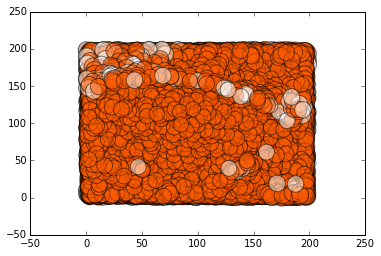

In [62]:
fig, ax = plt.subplots()
size = cell_df.age.values.astype(np.float) * 20 + 10
ax.scatter(cell_df.cx.values, cell_df.cy.values,
           s=size, c=cell_df.type.values, cmap='hot', alpha=0.5);

In [63]:
cell_df.xs(1, level='cell').head()

,type,age,area,cx,cy
t,,,,,
0,1,0,25,92.04,91.96
10,1,0,35,90.48571,91.65714
20,1,0,44,88.95455,90.72727
30,1,1,29,85.93103,89
40,1,1,38,84.84211,87.15789


In [64]:
edge_columns = ['srce_type', 'trgt_type']
edge_df = pd.DataFrame(index=e_idx, columns=edge_columns)

t_idx = e_idx.get_level_values(level='t')
srce_idx = e_idx.get_level_values(level='srce')
trgt_idx = e_idx.get_level_values(level='trgt')

srce_idx = pd.MultiIndex.from_arrays([t_idx, srce_idx], names=['t', 'cell'])
trgt_idx = pd.MultiIndex.from_arrays([t_idx, trgt_idx], names=['t', 'cell'])

edge_df['srce_type'] = cell_df['type'].loc[srce_idx].values
edge_df['trgt_type'] = cell_df['type'].loc[trgt_idx].values

edge_df['type_diff'] = edge_df.trgt_type == edge_df.srce_type

edge_df = edge_df.drop(0, level='srce')
edge_df = edge_df.drop(0, level='trgt')


In [65]:
pis = edge_df.type_diff.groupby(level=['t', 'srce']).apply(lambda df: special.binom(df.size, df.sum())/2**df.size)
pis.index.names = ['t', 'cell']
cell_df['pis'] = pis
entropy = - pis * np.log2(pis)
cell_df['entropy'] = entropy
cell_df.head()

type  age area     cx        cy      pis  entropy
t cell                                                  
0 0     NaN  NaN  NaN    NaN       NaN      NaN      NaN
  1       1    0   25  92.04     91.96  0.12500  0.37500
  2       1    0   25  92.04     97.04  0.12500  0.37500
  3       1    0   26     92  102.2692  0.03125  0.15625
  4       1    0   25  91.88    107.16  0.12500  0.37500

In [66]:
is_csc = (cell_df.type == 1).index 
is_npc = (cell_df.type == 2).index

n_csc = (cell_df.type == 1).groupby(level='t').sum()
n_npc = (cell_df.type == 2).groupby(level='t').sum()

area_csc = cell_df.area.loc[is_csc].groupby(level='t').apply(np.mean)
area_npc = cell_df.area.loc[is_npc].groupby(level='t').apply(np.mean)

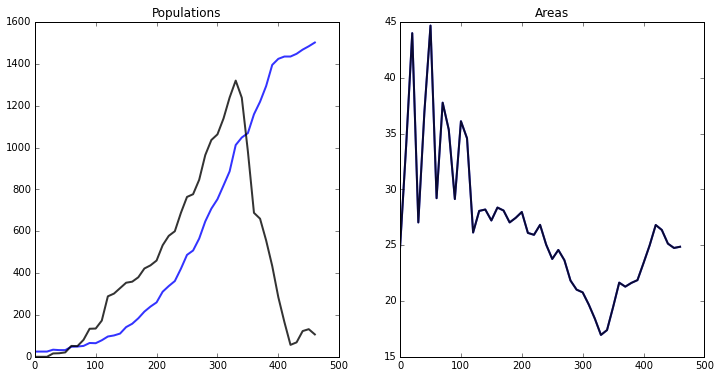

In [67]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

axes[0].plot(n_csc.index, n_csc, 'b-', lw=2, alpha=0.8)
axes[0].plot(n_npc.index, n_npc, 'k-', lw=2, alpha=0.8)
axes[0].set_title('Populations')

axes[1].plot(area_csc.index, area_csc, 'b-', lw=2, alpha=0.8)
axes[1].plot(area_npc.index, area_npc, 'k-', lw=2, alpha=0.8)
axes[1].set_title('Areas')


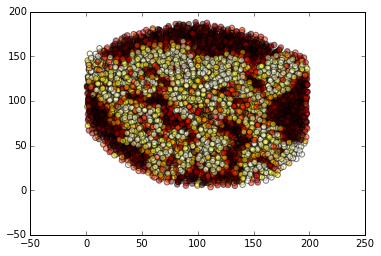

In [38]:
fig, ax = plt.subplots()
#size = cell_df.age.values.astype(np.float) * 20 + 10
size=30
ax.scatter(cell_df.cx.values, cell_df.cy.values,
           s=size, c=cell_df.entropy.values, cmap='hot', alpha=0.5);

In [ ]:
entropy_field = cell_type.copy().astype(np.float)
for lbl in v_idx:
    entropy_field[cell_id == lbl] = entropy.loc[lbl]

entropy_field = entropy_field / entropy_field.max()

In [ ]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cell_type[:100, :100], origin='lower', interpolation='nearest')
axes[1].imshow(entropy_field[:100, :100], cmap='hot', origin='lower', interpolation='nearest')

In [ ]:
entropy.loc[1:].mean()

In [ ]:
axes[1].imshow(entropy_field[:100, :100] * (cell_type[:100, :100] == 1),
               cmap='hot', origin='lower', interpolation='nearest')

In [ ]:
fig